# Classifier: Distinguishing Catheters from their Echoes

# Import Libraries:

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import matplotlib.patches as patches
from PIL import Image
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import cv2
import random

%matplotlib inline

# Get current/root directory
root = os.getcwd()

print("Using PyTorch Version %s" %torch.__version__)

Using PyTorch Version 1.4.0


# Classifier Parameters and Hyperparameters:

In [55]:
# Hyper-parameter settings
TOTAL_EPOCH = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
BATCH_SIZE = 11

class_arr = [0,1]
data_source = 'ounet' # ounet: unet output data, native: 

# Select patients randomly:

In [53]:
# Random data set select
patients_index = []
select_patients = 20

train_items = []
test_items = []

last_index = 0

for i in range(1, 101):
    if i != 57 and i != 112 and i != 179 and i != 184 and i != 120:
        patients_index.append(i)

sampled_list = random.sample(patients_index, select_patients)

for i in range(0, int(len(sampled_list)/2)):
    train_items.append(sampled_list[i])
    last_index = i

for i in range(i+1, len(sampled_list)):
    test_items.append(sampled_list[i])

print(sampled_list)

[9, 6, 1, 16, 74, 44, 52, 2, 43, 35, 17, 31, 51, 64, 13, 53, 75, 100, 78, 67]


# Load Training Data:

In [54]:
# Veriables
feature_map = []
classes = [] # Catheter: 1, Echo: 0
data_count = 0
file_count = 0

mags = []
phases = []
sectors = []
distances = []
sigs = []

cat_data = []
echo_data = []

# Read train data
train_loc = 'D:/SCA/256_256/feature_map/exp/train'
train_files = [f for f in listdir(train_loc) if isfile(join(train_loc, f))]

print('Loading train data...')

for file in train_files:
    
    f_arr = file.split('_')
    pn = int(f_arr[0])
    otype = f_arr[3]
    
    if pn in train_items:

        lbl = 1 if otype == 'c' else 0

        dataset=pd.read_csv(train_loc + '/' + file, header=None, delimiter='\t')   
        dataset = dataset.values

        one_object_features = []

        d_count = 0

        for ds in dataset:
            # Order: magnitude(0), phase(1), signature(2), sector(3), distance(4)
            if d_count <= 39:

                o_arr = ds[0].split(',')
                o_arr = np.array(o_arr)
                o_arr = o_arr.astype(np.float)

                mags.append(o_arr[0])
                phases.append(o_arr[1])
                sectors.append(o_arr[3])
                distances.append(o_arr[4])
                sigs.append(o_arr[2])

                one_object_features.append(o_arr[0])
                #one_object_features.append(o_arr[1])
                one_object_features.append(o_arr[2])
                #one_object_features.append(o_arr[3])
                one_object_features.append(o_arr[4])

                d_count += 1

                if d_count == 39:
                    continue


        one_object_features = np.array(one_object_features)

        # Data normalization
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(one_object_features.reshape(-1, 1))

        feature_map.append(scaled_data)
        classes.append(lbl)

        if lbl == 1:
            cat_data.append(scaled_data)
            echo_data.append(scaled_data)
        else:
            echo_data.append(scaled_data)

        data_count = data_count + 1
        print('\r' + str(data_count), end='')

        file_count += 1
    
feature_map = np.array(feature_map)
classes = np.array(classes)

print('\nDone!')

Loading train data...
4642
Done!


# Initialize UNET output before loading as Test data:

In [463]:
unet_patients = 55 #5,7,8,10,12,15,20,30
test_items = []
unet_pred_full = []

unet_accuracies=pd.read_csv('D:/SCA/256_256/roi/confidences.txt', header=None, delimiter="\t")
unet_accuracies = unet_accuracies.values

for ua in unet_accuracies:
    sp_res = ua[0].split(',')
    arr = sp_res[0].split('_')
    d = {'t':arr[3], 'f': sp_res[0], 'a': sp_res[1]}
    unet_pred_full.append(d)

if data_source == 'ounet':
    up_index = []

    for ds in unet_accuracies:
        x = ds[0].split(',')
        cl = x[0].split('_')
        up_index.append(int(cl[0]))

    patients_index = list(set(patients_index)) # total 55 patients
    up_index.sort()
    
    sampled_list = random.sample(up_index, unet_patients)

    for i in range(0, int(len(sampled_list))):
        test_items.append(sampled_list[i])
        
    print(sampled_list)

[9, 67, 90, 81, 108, 124, 146, 99, 1, 21, 16, 88, 14, 6, 94, 145, 66, 14, 91, 130, 37, 147, 131, 85, 130, 157, 134, 143, 104, 6, 45, 104, 6, 56, 163, 2, 119, 175, 81, 146, 37, 147, 90, 24, 146, 145, 102, 45, 175, 134, 91, 66, 108, 2, 81]


# Load Test Data:

In [471]:
# Load test data

# Veriables
test_feature_map = []
test_classes = [] # Catheter: 1, Echo: 0
test_files_title = []
data_count = 0

# Read test data
#test_loc = 'D:/SCA/256_256/feature_map/exp/train'
test_loc = 'D:/SCA/256_256/feature_map/test_unet'
test_files = [f for f in listdir(test_loc) if isfile(join(test_loc, f))]

print('Loading test data...')

for file in test_files:
    f_arr = file.split('_')
    pn = int(f_arr[0])
    otype = f_arr[3]
    
    if pn in test_items:
        
        if otype == 'e':
    
            lbl = 1 if otype == 'c' else 0

            dataset=pd.read_csv(test_loc + '/' + file, header=None, delimiter='\t')   
            dataset = dataset.values
            if len(dataset) == 0:
                print('null')

            one_object_features = []
            d_count = 0

            for ds in dataset:
                # Order: magnitude(0), phase(1), signature(2), sector(3), distance(4)

                if d_count <= 39:
                    o_arr = ds[0].split(',')
                    o_arr = np.array(o_arr)
                    o_arr = o_arr.astype(np.float)

                    one_object_features.append(o_arr[0])
                    #one_object_features.append(o_arr[1])
                    one_object_features.append(o_arr[2])
                    #one_object_features.append(o_arr[3])
                    one_object_features.append(o_arr[4])

                    d_count += 1

                    if d_count == 39:
                        continue

            data_count = data_count + 1
            print('\r' + str(data_count), end='')

            one_object_features = np.array(one_object_features)

            # Data normalization
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(one_object_features.reshape(-1, 1))

            test_feature_map.append(scaled_data)
            test_classes.append(lbl)
            test_files_title.append(file)
    
test_feature_map = np.array(test_feature_map)
test_classes = np.array(test_classes)
test_files_title = np.array(test_files_title)

test_feature_map = torch.from_numpy(test_feature_map).float()
test_classes = torch.from_numpy(test_classes).long()

print('\nDone!')

Loading test data...
11635
Done!


In [4]:
test_loc = 'D:/SCA/256_256/feature_map/test_unet'
test_files = [f for f in listdir(test_loc) if isfile(join(test_loc, f))]
img_slices = []

for file in test_files:
    f_arr = file.split('_')
    pno = int(f_arr[0])
    slc = int(f_arr[1])
    img_slices.append(str(pno)+'_'+str(slc))
    
print(len(set(img_slices)))

6660


# Map UNET Output Data:

In [472]:
# Get unet accuracies
unet_prediction_accuracies = []

print('Reading...')
if data_source == 'ounet':
    for item in test_files_title:
        fstr = item.split('.')[0]
        item = next(item for item in unet_pred_full if item["f"] == fstr)
        unet_prediction_accuracies.append(item)
        #print(item)
        
unet_prediction_accuracies = np.array(unet_prediction_accuracies)
        
print('Done!')

Reading...
Done!


# Conver numpy array of Training Data into Data Frame:

In [40]:
# Convert to pandas

pd_dataset = pd.DataFrame({'Freq. Coeff.': mags, 'Spec. Rot.': phases, 'Spec. Dev.': sigs, 'Sector': sectors, 'Distance': distances})
pd_dataset.head(10)

,Freq. Coeff.,Spec. Rot.,Spec. Dev.,Sector,Distance
0,0.898911,0.000000,-1.302566,0.0,0.000000
1,0.186340,-0.218669,0.708626,0.0,18.439089
2,0.185555,-0.218669,0.437338,0.0,18.439089
3,0.110231,-0.321751,0.682317,0.0,31.622777
4,0.110164,-0.321751,0.141897,0.0,31.622777
5,0.100436,0.000000,0.030294,0.0,19.000000
6,0.099856,0.000000,0.000000,0.0,19.000000
7,0.066827,-0.293589,0.000000,0.0,44.922155
8,0.066812,-0.293589,0.933359,0.0,44.922155
9,0.050743,0.000000,0.766496,0.0,35.000000


# Visualization of Correlation Matrix:

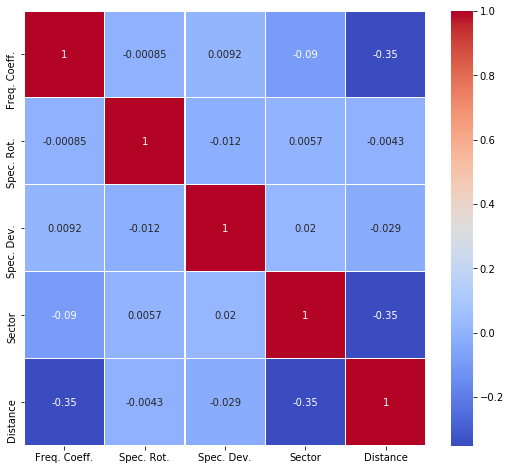

In [44]:
# Correlation between columns

corr_matrix = pd_dataset.corr()
plt.figure(figsize=(9, 8))
sns.heatmap(data = corr_matrix,cmap='coolwarm', annot=True, linewidths=0.2)

# Generate Batch of Training Features:

In [56]:
# Generate batch of features
group = len(feature_map)/BATCH_SIZE

batch_features = np.split(feature_map, group)
batch_features = np.array(batch_features)
batch_features = torch.from_numpy(batch_features).float()

batch_features.shape

torch.Size([422, 11, 120, 1])

# Generate Batch of Training Classes:

In [57]:
# Generate batch of classes
group = len(classes)/BATCH_SIZE

batch_classes = np.split(classes, group)
batch_classes = np.array(batch_classes)
batch_classes = torch.from_numpy(batch_classes).long()

batch_classes.shape

torch.Size([422, 11])

# Set training device: CPU or GPU:

In [58]:
# Set training device: CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


# Design Neural Network Architecture:

In [293]:
# Fully Connected Neural Network (FCCN) Architecture

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.classifier = nn.Sequential(
            
            nn.Linear(120, 50),
            nn.BatchNorm1d(50),
            nn.Dropout(0.30),
            nn.ReLU(),
            
            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(50, 30),
            #nn.BatchNorm1d(40),
            #nn.Dropout(0.1),
            nn.ReLU(),
            
            nn.Linear(30, 2),
            #nn.Softmax(dim=1)
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        x = x.view(-1, 120)
        
        x = self.classifier(x)
        
        return x


net = Net()
net = net.float()
net.to(device)

Net(
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=30, bias=True)
    (9): ReLU()
    (10): Linear(in_features=30, out_features=2, bias=True)
    (11): Sigmoid()
  )
)

# Define Loss Function:

In [294]:
# Loss function configuration

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=0.001) #, weight_decay=0.001

# Training the Neural Network:

In [295]:
# Training data on GPU

train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

print('Training started...\n')

for epoch in range(TOTAL_EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    end_loss = 0.0
    j = 0
    
    y_hat_classes = []
    
    for i in range(0, len(batch_features)):
        
        print('\rEPOCH ' + str(epoch+1) + '/'+str(TOTAL_EPOCH)+': Batch ' + str(i+1) + '/' + str(len(batch_features)), end='')
        
        inputs = batch_features[i].to(device)
        labels = batch_classes[i].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print(outputs)
        
        # print statistics
        running_loss += loss.item()
        end_loss= loss.item()
        
        j += 1
        
        #y_hat_class = np.where(outputs.detach().cpu().numpy()<0.5, 0, 1)
        _, predicted = torch.max(outputs, 1)
        #print(predicted)
        y_hat_class = predicted.cpu().numpy()
        
        #y_hat_classes.append(y_hat_class[0][1])
        #y_hat_classes.append(y_hat_class[1][1])
        y_hat_classes.append(y_hat_class)
        
    avg_loss = running_loss/j
    
    y_hat_classes = np.array(y_hat_classes)
    accuracy = np.sum(classes.reshape(-1,1)==y_hat_classes.reshape(-1,1)) / len(classes.reshape(-1,1))
    
    train_accuracy.append(accuracy)
    train_loss.append(avg_loss)

    print('\nEPOCH ' + str(epoch+1) + '/'+str(TOTAL_EPOCH)+'(DONE): ' + 'Loss = ' + str(avg_loss) + 
          '  Accuracy = ' + str(accuracy) + 
          ' (' + 'GPU: cuda:0 - ' + torch.cuda.get_device_name(0) + ')\n')

print('\nFinished Training')

Training started...

EPOCH 1/20: Batch 422/422
EPOCH 1/20(DONE): Loss = 0.6776466520759167  Accuracy = 0.6111589831968979 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 2/20: Batch 422/422
EPOCH 2/20(DONE): Loss = 0.6470409891616676  Accuracy = 0.6510124946143904 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 3/20: Batch 422/422
EPOCH 3/20(DONE): Loss = 0.6263099961794948  Accuracy = 0.6512279190004309 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 4/20: Batch 422/422
EPOCH 4/20(DONE): Loss = 0.613370144889818  Accuracy = 0.6602757432141318 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 5/20: Batch 422/422
EPOCH 5/20(DONE): Loss = 0.6031061723051478  Accuracy = 0.6744937526928049 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 6/20: Batch 422/422
EPOCH 6/20(DONE): Loss = 0.5955109424641912  Accuracy = 0.6956053425247738 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 7/20: Batch 422/422
EPOCH 7/20(DONE): Loss = 0.5890778541847428  Accuracy = 0.7048685911245153 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 8/20: Batch 422/422
EPOCH 8/2

# Visualization of Training Loss and Accuracy:

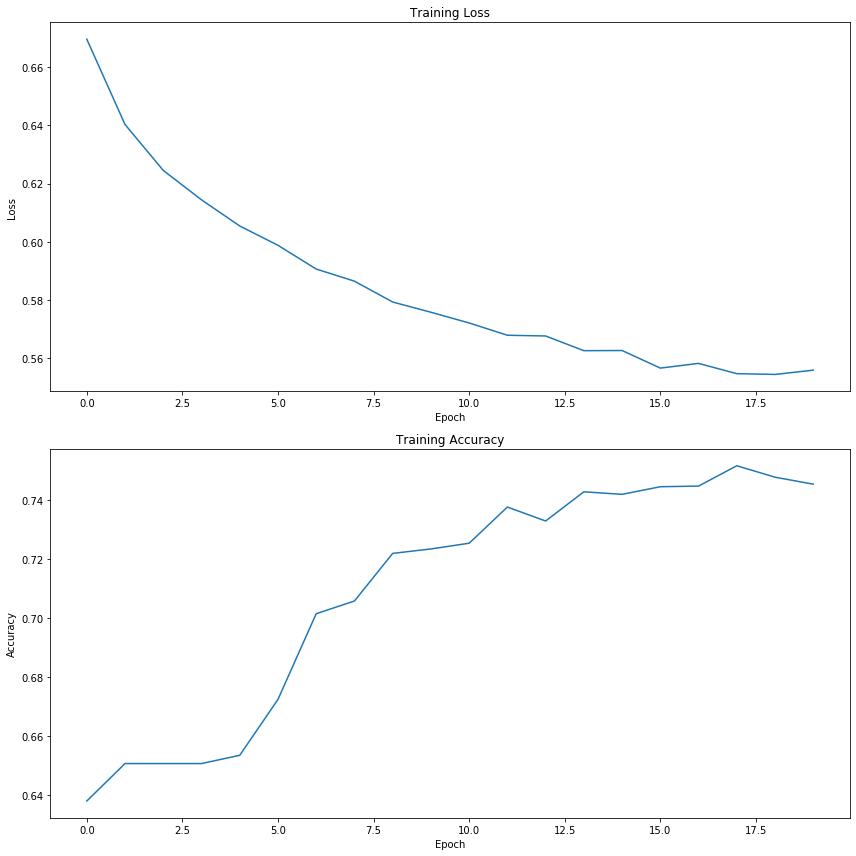

In [83]:
# Training accuracy and loss plotting

fig, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].plot(train_loss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

# Save Trained Model:

In [218]:
# Save trained model

PATH = 'D:/SCA/256_256/nn_output/model_071.net'
torch.save(net, PATH)


C:\Users\gc\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Generate Predicted Probability for Test Data:

In [473]:
# Compute neural network output

outputs = net(test_feature_map.to(device))#.to(device)
print(outputs)

tensor([[0.5212, 0.4060],
        [0.2479, 0.7015],
        [0.5775, 0.3875],
        ...,
        [0.5652, 0.3797],
        [0.0066, 0.9936],
        [0.2766, 0.6786]], device='cuda:0', grad_fn=<SigmoidBackward>)


# Evaluate Bulk Accuracies:

In [456]:
res_arr = []
thrs = []
for c in range(40,90):

    res = []
    t_out = outputs
    
    op = 0

    for i in range(0, len(t_out)):
        #print(t_out)
        op = c/100
        v = t_out[i][1]
        if v > op :
            res.append(1)

        else:
            res.append(0)

    res = np.array(res)        
    predicted = torch.from_numpy(res)

    nd_predict = predicted.cpu().numpy()
    
    
    #####
    correct = 0
    total = 0

    with torch.no_grad():

        total = test_classes.size(0)
        correct = (nd_predict == test_classes.numpy()).sum().item()

    acc = (correct / total)
    res_arr.append(acc)
    thrs.append(op)

    #print('Accuracy on '+ str(total) +' testset: ' + str(acc) + '  Threshold = ' + str(op))
    
m=max(res_arr)
i=res_arr.index(max(res_arr))
acu = "%.2f" % m
print('Accuracy:' + str(acu))
print('Threshold: ' + str((i+40)/100))

Accuracy:0.79
Threshold: 0.4


# Evaluate Accuracy:

In [476]:
res = []
pred_accuracy_dict = []
t_out = outputs

op = 0
print('Computing accuracy...')
for i in range(0, len(t_out)):
    #print(t_out)
    #op = c/100
    v = t_out[i][0]
    #print(str(v))
    if v > 0.5:
        res.append(1)
        d = {'t': 'c', 'f': test_files_title[i].split('.')[0], 'a': t_out[i][1]}
        pred_accuracy_dict.append(d)

    else:
        res.append(0)
        d = {'t': 'e', 'f': test_files_title[i].split('.')[0], 'a': t_out[i][0]}
        pred_accuracy_dict.append(d)

res = np.array(res)        
predicted = torch.from_numpy(res)

nd_predict = predicted.cpu().numpy()


#####
correct = 0
total = 0

with torch.no_grad():

    total = test_classes.size(0)
    correct = (nd_predict == test_classes.numpy()).sum().item()

acc = (correct / total)

acu = "%.4f" % acc
print('Accuracy on '+ str(total) +' testset: ' + str(acu))

Computing accuracy...
Accuracy on 11635 testset: 0.7589


In [477]:
higher_count = 0
higher_val = []
high_conf = []
avg_higher=0
pfcnn_sum = 0

lower_count = 0
lower_val = []
low_conf = []
avg_lower=0
unet_sum = 0

equal_count = 0
equal_val = []

unet_conf_arr = []
pfcnn_conf_arr = []

for i in range(0, len(t_out)):
    unet_dict = unet_prediction_accuracies[i]
    native_dict = pred_accuracy_dict[i]
    
    conf_unet = float(unet_dict.get('a'))
    conf_pfcnn = float(native_dict.get('a'))
    
    unet_conf_arr.append(conf_unet)
    pfcnn_conf_arr.append(conf_pfcnn)
    
    unet_sum += conf_unet
    pfcnn_sum += conf_pfcnn
    
    if conf_pfcnn > conf_unet:
        higher_count += 1
        hv = conf_pfcnn-conf_unet
        higher_val.append(hv)
        high_conf.append(conf_pfcnn)
        
    elif conf_pfcnn < conf_unet:
        lower_count += 1
        lv = conf_pfcnn-conf_unet
        lower_val.append(lv)
        low_conf.append(conf_pfcnn)
        
    elif conf_pfcnn == conf_unet:
        equal_count += 1
        lower_val.append(conf_pfcnn)
        
#avg_higher_diff=sum(higher_val) / len(higher_val)
avg_lower_diff=sum(lower_val) / len(lower_val)
#avg_high_conf = sum(high_conf) / len(high_conf)
avg_low_conf = sum(low_conf) / len(low_conf)
avg_pfcnn = pfcnn_sum/len(t_out)
avg_unet = unet_sum/len(t_out)
        
## Reporting ##
print('REPORTING FOR E LIST:\n')
print('Higher confidence in PFCNN than unet: ' + str(higher_count) + ' roi out of '+str(len(t_out)))
print('Lower confidence in Probing FCNN than unet: ' + str(lower_count) + ' roi out of '+str(len(t_out))+'\n')

print('Average higher difference of confidence (D1): '+str(avg_higher_diff))
print('Average lower difference of confidence (D2): '+str(avg_lower_diff))
print('Difference (D1 - D2): '+str(avg_higher_diff-(-avg_lower_diff))+'\n')

print('Average higher confidence: '+str(avg_high_conf))
print('Average lower confidence: '+str(avg_low_conf)+'\n')

print('Average confidence in unet: '+str(avg_unet))
print('Average confidence in pfcnn: '+str(avg_pfcnn))
#print('Their average ((pfcnn+unet)/2): '+str((avg_pfcnn+avg_unet)/2))
print('Their difference (pfcnn-unet): '+str(avg_unet-avg_pfcnn)+'\n')

print('Equal confidence in Probing FCNN and unet: ' + str(equal_count) + ' out of '+str(len(t_out)))

print('###################\n\n')

REPORTING FOR E LIST:

Higher confidence in PFCNN than unet: 0 roi out of 11635
Lower confidence in Probing FCNN than unet: 11635 roi out of 11635

Average higher difference of confidence (D1): 0.20618377498093005
Average lower difference of confidence (D2): -0.5122380955460709
Difference (D1 - D2): -0.30605432056514087

Average higher confidence: 0.9145799951595404
Average lower confidence: 0.1228411159502727

Average confidence in unet: 0.6350792114963449
Average confidence in pfcnn: 0.1228411159502727
Their difference (pfcnn-unet): 0.5122380955460722

Equal confidence in Probing FCNN and unet: 0 out of 11635
###################




In [478]:
# Compute std dev.

import statistics 
from statistics import mean 

# Standard deviation of list 
# Using pstdev() 
res_unet = statistics.pstdev(unet_conf_arr) 
res_pfcnn = statistics.pstdev(pfcnn_conf_arr) 

average_unet = mean(unet_conf_arr) 
average_pfcnn = mean(pfcnn_conf_arr) 
  
# Printing result 
print("Standard deviation of Tupor's sample is : " + str(res_unet))
print("Standard deviation of pfcnn sample is : " + str(res_pfcnn))
print("Average confidence of Tupor's sample is : " + str(average_unet))
print("Average confidence of pfcnn sample is : " + str(average_pfcnn))

Standard deviation of Tupor's sample is : 0.10265822331369646
Standard deviation of pfcnn sample is : 0.13408694290643805
Average confidence of Tupor's sample is : 0.6350792114963473
Average confidence of pfcnn sample is : 0.1228411159502727


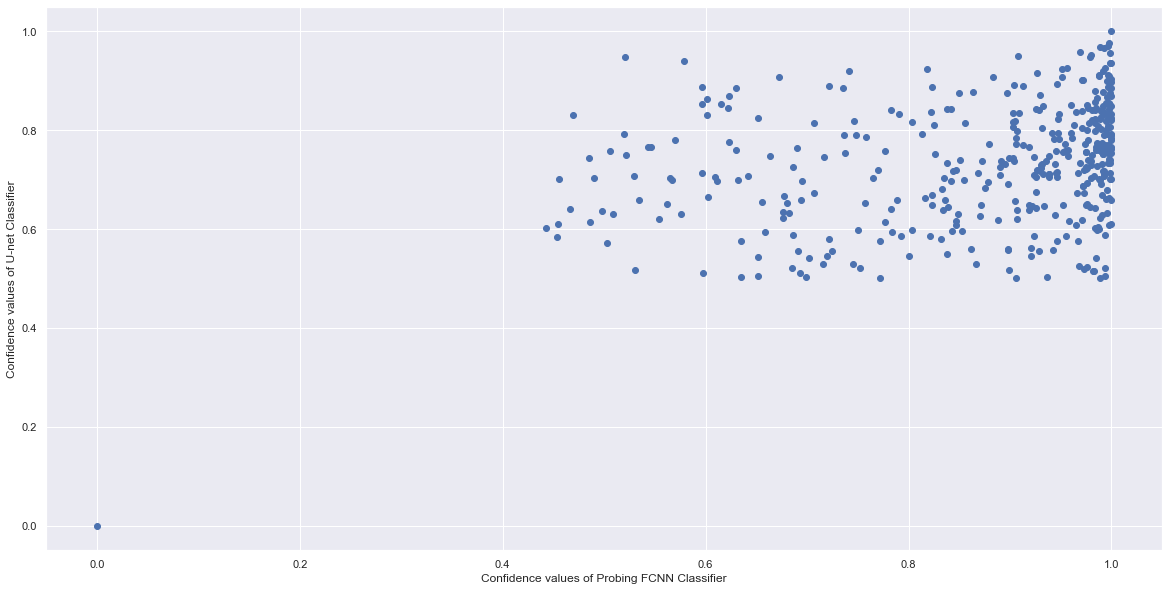

In [462]:
x_mypred = []
y_unetpred = []

x_ = []
y_ = []

index_list = random.sample(range(0,len(pred_accuracy_dict)), 400)

for indx in index_list:
    x_mypred.append(pred_accuracy_dict[indx].get('a'))
    
for indx in index_list:
    y_unetpred.append(unet_prediction_accuracies[indx].get('a'))
    
x_mypred = np.array(x_mypred)
y_unetpred = np.array(y_unetpred)

for itm in x_mypred:
    x_.append(itm.item())
    
for itm in y_unetpred:
    y_.append(itm.item())

x_.append(0.0)
y_.append(0.0)
x_.append(1.0)
y_.append(1.0)
    
x_ = np.array(x_)
y_ = np.array(y_)

x_ = x_.astype(np.float)
y_ = y_.astype(np.float)

plt.rcParams["figure.figsize"] = (20,10)

plt.xlabel('Confidence values of Probing FCNN Classifier')
plt.ylabel('Confidence values of U-net Classifier')
#plt.title('scatter plot: probing fcnn confidence score vs. unet confidence score (E list 100 points)')

plt.plot(x_, y_, linestyle='none', marker='o');
plt.show()


In [449]:
combined_predict = []
comb_pred_accuracy_dict = []

for i in range(0, len(t_out)):
    unet_dict = unet_prediction_accuracies[i]
    native_dict = pred_accuracy_dict[i]
    
    new_accuracy = (float(unet_dict.get('a'))+float(native_dict.get('a')))/2
        
    if new_accuracy > 0.7:
        combined_predict.append(1)

        d = {'t': 'c', 'f': unet_dict.get('f'), 'a': new_accuracy}
        comb_pred_accuracy_dict.append(d)

    else:
        combined_predict.append(0)

        d = {'t': 'e', 'f': unet_dict.get('f'), 'a': new_accuracy}
        comb_pred_accuracy_dict.append(d)
    
combined_predict = np.array(combined_predict)

# Compute combined accuracy
correct = 0
total = 0

with torch.no_grad():

    total = test_classes.size(0)
    correct = (combined_predict == test_classes.numpy()).sum().item()

acc = (correct / total)

acu = "%.4f" % acc
print('Accuracy on '+ str(total) +' testset: ' + str(acu))

Accuracy on 5094 testset: 0.9990


# Combining Output of two Neural Networks:

In [220]:
combined_predict = []
comb_pred_accuracy_dict = []

for i in range(0, len(t_out)):
    unet_dict = unet_prediction_accuracies[i]
    native_dict = pred_accuracy_dict[i]
    
    if unet_dict.get('t') == native_dict.get('t'):
        new_accuracy = (float(unet_dict.get('a'))+float(native_dict.get('a')))/2
        
        if native_dict.get('t') == 'c' and new_accuracy > 0.55:
            combined_predict.append(1)
            
            d = {'t': 'c', 'f': unet_dict.get('f'), 'a': new_accuracy}
            comb_pred_accuracy_dict.append(d)
            
        elif native_dict.get('t') == 'c' and new_accuracy < 0.55:
            combined_predict.append(0)
            
            d = {'t': 'e', 'f': unet_dict.get('f'), 'a': new_accuracy}
            comb_pred_accuracy_dict.append(d)
            
        elif native_dict.get('t') == 'e' and new_accuracy < 0.55:
            combined_predict.append(0)
            
            d = {'t': 'e', 'f': unet_dict.get('f'), 'a': new_accuracy}
            comb_pred_accuracy_dict.append(d)
            
        elif native_dict.get('t') == 'e' and new_accuracy > 0.55:
            combined_predict.append(1)
            
            d = {'t': 'c', 'f': unet_dict.get('f'), 'a': new_accuracy}
            comb_pred_accuracy_dict.append(d)
            
            
    else:
        unet_cat_prob = float(unet_dict.get('a'))
        unet_echo_prob = 1-unet_cat_prob

        native_echo_prob = float(native_dict.get('a'))
        native_cat_prob = 1-native_echo_prob

        new_accuracy_cat = (unet_cat_prob+native_cat_prob)/2
        new_accuracy_echo = (unet_echo_prob+native_echo_prob)/2
        
        if new_accuracy_cat > new_accuracy_echo:
            combined_predict.append(1)
            
            d = {'t': 'c', 'f': unet_dict.get('f'), 'a': new_accuracy_cat}
            comb_pred_accuracy_dict.append(d)
            
        else:
            combined_predict.append(0)
            
            d = {'t': 'e', 'f': unet_dict.get('f'), 'a': new_accuracy_echo}
            comb_pred_accuracy_dict.append(d)
            
        # Or try the following
        '''if new_accuracy_cat > 0.55:
            combined_predict.append(1)
        else:
            combined_predict.append(0)'''
    
combined_predict = np.array(combined_predict)

# Compute combined accuracy
correct = 0
total = 0

with torch.no_grad():

    total = test_classes.size(0)
    correct = (combined_predict == test_classes.numpy()).sum().item()

acc = (correct / total)

acu = "%.4f" % acc
print('Accuracy on '+ str(total) +' testset: ' + str(acu))

Accuracy on 2089 testset: 0.7042


In [112]:
combined_predict = []
comb_pred_accuracy_dict = []

for i in range(0, len(t_out)):
    unet_dict = unet_prediction_accuracies[i]
    native_dict = pred_accuracy_dict[i]
    
    new_accuracy = (float(unet_dict.get('a'))+float(native_dict.get('a')))/2
        
    if new_accuracy > 0.55:
        combined_predict.append(1)
        
    else:
        combined_predict.append(0)
    
combined_predict = np.array(combined_predict)

# Compute combined accuracy
correct = 0
total = 0

with torch.no_grad():

    total = test_classes.size(0)
    correct = (combined_predict == test_classes.numpy()).sum().item()

acc = (correct / total)

acu = "%.4f" % acc
print('Accuracy on '+ str(total) +' testset: ' + str(acu))

Accuracy on 13295 testset: 0.7789


In [105]:
print('Total test data: ' + str(len(t_out)))
print('Total catheter predicted by unet: ' + str(len(t_out)))
print('Total echo predicted by unet: ' + str(len(t_out)))

Total test data: 13295
Total catheter predicted by unet: 13295
Total echo predicted by unet: 13295


In [110]:
# The outputs are energies for 2 classes. 
# The higher the energy for a class, the more the network thinks that the feature is of the particular class. 
# Get the index of the highest energy

_, predicted = torch.max(outputs, 1)
nd_predict = predicted.cpu().numpy()
predicted

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [66]:
# Compute Accuracy on test result

correct = 0
total = 0

with torch.no_grad():
    
    total = test_classes.size(0)
    correct = (nd_predict == test_classes.numpy()).sum().item()
    
acc = (correct / total)

print('Accuracy on '+ str(total) +' testset: ' + str(acc))

Accuracy on 21109 testset: 0.7871050262921029


In [67]:
# Confusion matrix
# confusion_matrix(y_true, y_pred)

results = confusion_matrix(nd_predict, test_classes.numpy(), labels=[0, 1])

print('Confusion Matrix :')
print(results) 
#print('Accuracy Score :',accuracy_score(test_classes, predicted))
#print('Report : ')
#print(classification_report(test_classes, predicted))

Confusion Matrix :
[[   56     5]
 [ 4489 16559]]


In [ ]:
# Write NN output


image_slice = 0
xys = []
r_path = 'D:/SCA/256_256/nn_output/bounding_boxes/'

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

#len(nd_predict)
for i in range(0, len(nd_predict)):
    
    print(test_files_title[i])
    f_arr = test_files_title[i].split('_')
    
    p_sl = f_arr[0]
    i_s = f_arr[1]
    i_sub = f_arr[2]
    o_type = f_arr[3]
    x_val = f_arr[4]
    y_val = f_arr[5].split('.')[0]
    
    img_path = r_path + p_sl + '/'+ i_s + '_' + i_sub +'.png'
    imgcv = cv2.imread(img_path)
    
    x1 = int(x_val)-16
    y1 = int(y_val)-16
    x2 = int(x_val)+16
    y2 = int(y_val)+16
    
    #conf = 0.99
    
    #label = 'C' if nd_predict[i] == 1 else 'E'
    label = 'C' if o_type == 'c' else 'E'
    
    cv2.rectangle(imgcv,(x1,y1),(x2,y2),(0,255,0),1)
    
    labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,0.4,2)
    
    _x1 = x1
    _y1 = y1
    _x2 = _x1+labelSize[0][0]
    _y2 = y1-int(labelSize[0][1])
    
    cv2.rectangle(imgcv,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
    cv2.putText(imgcv,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.4,(0,0,0),1)
    
    cv2.imwrite(img_path,imgcv)